NameError: ignored

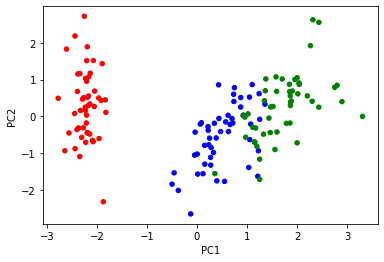

In [ ]:
!pip install pyod

import numpy as np
import pandas as pd
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
X = df.loc[:,0:3]
y = df.loc[:,4]
#When you do unsupervised learning, it is always a safe step to standardize the predictors
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)

# Training and Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()

y_color = np.where(y=='Iris-setosa','red',
            np.where(y=='Iris-versicolor','blue','green'))
x_pca.plot(kind='scatter', x='PC1', y='PC2',c=y_color)
clf1 = IForest(behaviour="new", max_samples=100) 
clf1.fit(X_train)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.05, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()
clf2 = IForest(behaviour="new", max_samples=80) 
clf2.fit(X_train)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf2 Anomaly Scores")
plt.show()
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.04, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()

clf3 = IForest(behaviour="new", max_samples=60) 
clf3.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf3 Anomaly Scores")
plt.show()

X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.03, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()


from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)
train_scores_norm.shape
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()
df_test = X_test.copy()
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<2, 0, 1)
df_test['y_by_average_cluster'].value_counts()

df_test.groupby('y_by_average_cluster').mean().round(2)
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()
df_test = X_test.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<2, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

df_test.groupby('y_by_maximization_cluster').mean().round(2)
